In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Sersic1D
from astropy.modeling import fitting, Fittable1DModel

import kuaizi as kz

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

---
in log space

In [200]:
class Spergel1D(Fittable1DModel):
    from astropy.modeling import Parameter

    amplitude = Parameter(default=1, description="Surface brightness at r_eff")
    r_eff = Parameter(default=1, description="Effective (half-light) radius")
    nu = Parameter(default=0.5, description="Spergel Index")
    _kv = None
    
    _z = np.array(
            [-0.00788962, 0.0735303, -0.27770785, 0.99483285, 1.25227402]
        )
    
#     @classmethod
    def evaluate(cls, log_r, amplitude, r_eff, nu):
        """
        One dimensional Sersic profile function.
        
        Here the amplitude is L0, which is just the total luminosity
        """

        if cls._kv is None:
            from scipy.special import kv, gamma
            cls._kv = kv
            cls._gamma = gamma
        
        r = 10**log_r
        cnu = cls._z[0] * nu ** 4 + cls._z[1] * nu ** 3 + cls._z[2] * nu ** 2 + cls._z[3] * nu + cls._z[4]
        x = np.sqrt((r / r_eff)**2 + 1e-6) * cnu
        y = amplitude * cnu**2 / (2 * np.pi * r_eff**2) * (x / 2) ** nu * cls._kv(nu, x) / cls._gamma(nu + 1)
        return np.log10(y)
    
    @property
    def input_units(self):
        if self.r_eff.unit is None:
            return None
        return {self.inputs[0]: self.r_eff.unit}

    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        return {'r_eff': inputs_unit[self.inputs[0]],
                'amplitude': outputs_unit[self.outputs[0]]}

In [386]:
# from kuaizi.measure import bn
from scipy.special import gamma, gammainc, gammaincinv

def bn(n):
    return gammaincinv(2. * n, 0.5)

# def sersic_L0(amplitude, r_eff, n):
#     b = bn(n)
#     h = r_eff / b**n
#     I0 = amplitude * np.e**b
#     return np.pi * I0 * h**2 * gamma(2 * n + 1)

def sersic_LR(R, amplitude, r_eff, n):
    b = bn(n)
    x = b * (R / r_eff)**(1 / n)
    return amplitude * r_eff**2 * 2 * np.pi * n * np.exp(b) / (b)**(2 * n) * (gamma(2 * n) * gammainc(2. * n, x))

def sersic_L0(amplitude, r_eff, n):
    b = bn(n)
    return amplitude * r_eff**2 * 2 * np.pi * n * np.exp(b) / (b)**(2 * n) * gamma(2. * n)

In [387]:
sersic_LR(3, 1, 1, 0.6)

9.640863076348264

In [388]:
sersic_L0(1, 1, 0.6)

9.701107074667371

In [408]:
ns = np.linspace(0.6, 5.5, 50)
[sersic_LR(5, 1, 1, n) / sersic_L0(1, 1, n) for n in ns]

[0.9999957524264151,
 0.9999387621532467,
 0.999682958796218,
 0.9990394636421112,
 0.997870578448509,
 0.9961232491035696,
 0.9938137566504627,
 0.9909997611736306,
 0.9877571752648637,
 0.9841653446482068,
 0.9802989734009064,
 0.976224449880228,
 0.9719987244303286,
 0.9676695310842406,
 0.9632762355876562,
 0.9588509104352287,
 0.954419428647916,
 0.9500024770500681,
 0.9456164494798734,
 0.941274211515426,
 0.9369857434495261,
 0.9327586746850054,
 0.9285987245888793,
 0.9245100644441628,
 0.9204956137292447,
 0.9165572822006974,
 0.9126961674911499,
 0.9089127163141845,
 0.9052068559518877,
 0.9015781014973495,
 0.8980256433202892,
 0.8945484183958087,
 0.8911451684582323,
 0.8878144873895855,
 0.8845548598034377,
 0.8813646924207744,
 0.8782423395393903,
 0.8751861236590136,
 0.8721943521301943,
 0.8692653305373514,
 0.8663973733981745,
 0.8635888126572034,
 0.8608380043663045,
 0.8581433338752277,
 0.8555032197985688,
 0.8529161169788353,
 0.85038051862705,
 0.8478949577908833,

In [512]:
from scipy.optimize import root
n = 4.5
f = lambda x: sersic_LR(x, 1, 1, n) / sersic_L0(1, 1, n) - 0.98
R_max = np.log10(fsolve(f, 2))

In [516]:
ser = Sersic1D(amplitude=1, r_eff=1, n=n)

log_x = np.linspace(-1.5, R_max, 400)
log_y = np.log10(ser(10**log_x))

mask = np.isfinite(log_y)

david = Spergel1D(amplitude=sersic_L0(1, 1, n), 
                  r_eff=1, 
                  nu=0.5 - 0.36 * (n - 1)
                 )
# david.r_eff.fixed = True
# david.amplitude.fixed = True

fit_t = fitting.LevMarLSQFitter()
david = fit_t(david, log_x[mask], log_y[mask])
david

<Spergel1D(amplitude=24.94834946, r_eff=1.18058123, nu=-0.74378911)>

In [517]:
david.amplitude.value, sersic_L0(1, 1, n)

(24.948349455243672, 23.993386622393615)

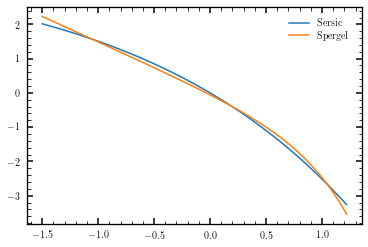

In [518]:
plt.plot(log_x, log_y, label='Sersic')
plt.plot(log_x, david(log_x), label='Spergel')
# plt.yscale('log')
# plt.ylim(1e-10, 1)
# plt.xscale('log')

plt.legend()

In [620]:
david_nus = []
david_res = []
david_amp = []
sersic_amp = []

r_eff = 1
ns = np.linspace(0.5, 4.5, 100)
for n in ns:
    f = lambda x: sersic_LR(x, 1, 1, n) / sersic_L0(1, 1, n) - 0.98
    R_max = np.log10(fsolve(f, 2))

    ser = Sersic1D(amplitude=1, r_eff=r_eff, n=n)
    log_x = np.linspace(-1.5, R_max, 400)
    log_y = np.log10(ser(10**log_x))

    david = Spergel1D(amplitude=1 * sersic_L0(1, r_eff, n), 
                      r_eff=r_eff, 
                      nu=0.5 - 0.36 * (n - 1))
    david.r_eff.fixed = True
    david.amplitude.fixed = True

    fit_t = fitting.LevMarLSQFitter()
    david = fit_t(david, log_x, log_y)

    david_nus.append(david.nu.value)
    david_res.append(david.r_eff.value)
    sersic_amp.append(sersic_L0(1, r_eff, n))
    david_amp.append(david.amplitude.value)
    
david_nus = np.array(david_nus)
david_res = np.array(david_res)
sersic_amp = np.array(sersic_amp)
david_amp = np.array(david_amp)

In [621]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=18)

Parameter('nu', value=3.6610328077585423)
Parameter('nu', value=-0.6608878642754077)


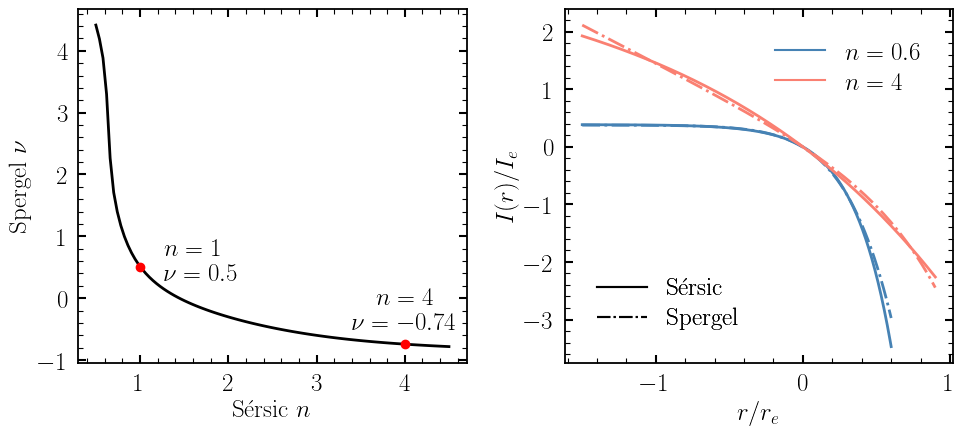

In [627]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.7))

axes[0].plot(ns, david_nus, lw=2, c='k')
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xlabel(r'S\'ersic $n$')
axes[0].set_ylabel(r'Spergel $\nu$')

axes[0].plot(1, 0.5, 'ro')
axes[0].text(1.6, 0.7, r'$n=1$', ha='center')
axes[0].text(1.7, 0.3, r'$\nu=0.5$', ha='center')

axes[0].plot(4, -0.7441118441297985, 'ro')
axes[0].text(4, -0.1, r'$n=4$', ha='center')
axes[0].text(4, -0.5, r'$\nu=-0.74$', ha='center')


r_eff = 1
threshs = [0.98, 0.95]
rmaxs = [0.6, 0.9]
lss = ['-', '-.']
cs = ['steelblue', 'salmon']

for k, n in enumerate([0.6, 4]):
    f = lambda x: sersic_LR(x, 1, 1, n) / sersic_L0(1, 1, n) - threshs[k]
    R_max = np.log10(fsolve(f, 2))

    ser = Sersic1D(amplitude=1, r_eff=r_eff, n=n)
    log_x = np.linspace(-1.5, R_max, 400)
    log_y = np.log10(ser(10**log_x))

    david = Spergel1D(amplitude=1 * sersic_L0(1, r_eff, n), 
                      r_eff=r_eff, 
                      nu=0.5 - 0.36 * (n - 1))
    david.r_eff.fixed = True
    david.amplitude.fixed = True

    fit_t = fitting.LevMarLSQFitter()
    david = fit_t(david, log_x, log_y)
    print(david.nu)
    log_x = np.linspace(-1.5, rmaxs[k], 400)
    log_y = np.log10(ser(10**log_x))
    axes[1].plot(log_x, log_y, label='Sersic', lw=2, ls='-', c=cs[k])
    axes[1].plot(log_x, david(log_x), label='Spergel', lw=2, ls='-.', c=cs[k])

axes[1].set_xlabel(r'$r/r_e$')
axes[1].set_ylabel(r'$I(r)/I_e$')

import matplotlib.lines as mlines
lines = [mlines.Line2D([], [], color='steelblue', label=r'$n=0.6$'), 
         mlines.Line2D([], [], color='salmon', label=r'$n=4$')]
lgd1 = axes[1].legend(handles=lines, fontsize=18, loc='upper right')#, bbox_to_anchor=(0., 1.0, 1., .0))
axes[1].add_artist(lgd1)


import matplotlib.lines as mlines
lines = [mlines.Line2D([], [], color='k', ls='-', label=r'S\'ersic'), 
         mlines.Line2D([], [], color='k', ls='-.', label=r'Spergel')]
lgd2 = axes[1].legend(handles=lines, fontsize=18, loc='lower left')#, bbox_to_anchor=(0., 1.0, 1., .0))
axes[1].add_artist(lgd2)


plt.subplots_adjust(wspace=0.2)

plt.tight_layout()

plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/spergel_sersic_calib.pdf',
            bbox_inches='tight', dpi=50)

In [286]:
from kuaizi.measure import nu_to_n

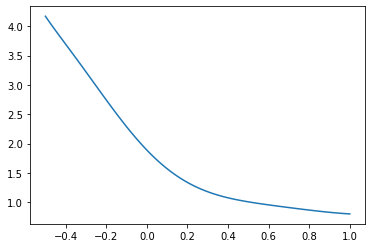

In [287]:
x = np.linspace(-0.5, 1.0, 100)
plt.plot(x, nu_to_n(x))

---

### Central SB to average SB

In [4]:
from kuaizi.measure import cal_mue, cal_mu0

In [25]:
ns = np.linspace(0.6, 2, 100)

diff = cal_mu0(ns, 5, 20) - cal_mue(ns, 5, 20) 

Text(0, 0.5, '$\\mu_{0} - \\overline{\\mu}_{\\rm eff}$')

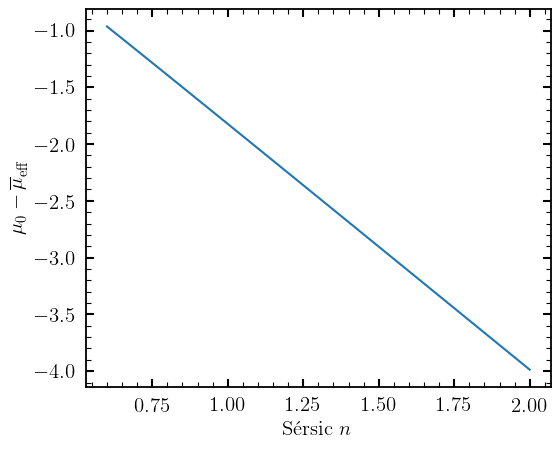

In [26]:
plt.plot(ns, diff)

plt.xlabel(r'S\'ersic $n$')
plt.ylabel(r'$\mu_{0} - \overline{\mu}_{\rm eff}$')